In [2]:
from __future__ import print_function

from IPython.display import Image
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import os, shutil
import pickle
import time

import tensorflow as tf

%matplotlib inline

RUN_NUMBER = 0

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/MNIST_data', one_hot=True)

print("train")
train_data = mnist.train.images.reshape(55000, 28, 28, 1)
print(train_data.shape)

train_labels = mnist.train.labels
print(train_labels.shape)


print("validation")
validation_data = mnist.validation.images.reshape(5000, 28, 28, 1)
print(validation_data.shape)

validation_labels = mnist.validation.labels
print(validation_labels.shape)


print("test")
test_data = mnist.test.images.reshape(10000, 28, 28, 1)
print(test_data.shape)

test_labels = mnist.test.labels
print(test_labels.shape)

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
train
(55000, 28, 28, 1)
(55000, 10)
validation
(5000, 28, 28, 1)
(5000, 10)
test
(10000, 28, 28, 1)
(10000, 10)


In [4]:
# Utility Functions
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def plot_log_data(log_data):
    plt.ylim(-5,110)

    plt.plot(log_data['validation_acc'], color="red", label='Validation Acc')
    plt.plot(log_data['mini_batch_acc'], color="blue", label='Mini Batch Acc')
    plt.plot(log_data['mini_batch_loss'], color="green", label='Mini Batch Loss (Scaled)')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
def delete_folder_content(path_to_folder):
    for the_file in os.listdir(path_to_folder):
        file_path = os.path.join(path_to_folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

In [15]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
    stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

IndentationError: expected an indented block (<ipython-input-15-42d4954309fb>, line 6)

In [6]:
param = {
    "image_size" : 28,
    "num_labels" : 10,
    "num_channels" : 1,
    "batch_size" : 128,
    "patch_size" : 5,
    "pooling_patch_size" : 5,
    "depth" : 16,
    "num_hidden0" : 120,
    "num_hidden1" : 84,
    "num_steps" : 20001,
    "dropout_prob1" : 2,
    "l2_regularization_rate" : 0.00001,
    "learning_startrate" : 0.01,
    "learning_decay" : 0.97,
    "learning_decay_steps" : 4000,
    "num_log_steps" : 500, 
    "log_folder" : "../logs"
}

In [7]:
def conv_pooling_relu(data, kernel_shape, bias_shape, stride):
    
    with tf.name_scope('weights'):
      weights = tf.get_variable("weights", kernel_shape,
          initializer=tf.truncated_normal_initializer(stddev=0.1))
    
      variable_summaries(weights)
    
    with tf.name_scope('biases'):
      biases = tf.get_variable("biases", bias_shape,
          initializer=tf.constant_initializer(0.1))
    
      variable_summaries(biases)
    
    with tf.name_scope('conv_before_activation'):
      conv = tf.nn.conv2d(data, weights,
          strides=[1, stride, stride, 1], padding='SAME')
    
      variable_summaries(conv)
    
    with tf.name_scope('conv_after_activation'):    
      conv_relu = tf.nn.relu(conv + biases)
    
      variable_summaries(conv_relu)
    
    with tf.name_scope('pooling'):
      pool = tf.nn.max_pool(conv_relu, ksize=[1, 1, 1, 1],
                        strides=[1, 1, 1, 1], padding='SAME')
      variable_summaries(pool)
    
    return pool

In [8]:
def conv_relu(data, kernel_shape, bias_shape, stride):
    
    weights = tf.get_variable("weights", kernel_shape,
        initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    biases = tf.get_variable("biases", bias_shape,
        initializer=tf.constant_initializer(0.0))
    
    conv = tf.nn.conv2d(data, weights,
        strides=[1, stride, stride, 1], padding='SAME')
    
    conv_relu = tf.nn.relu(conv + biases)
    
    return conv_relu

In [9]:
def relu(data, output_shape):
    input_shape = [ data.get_shape().as_list()[1], output_shape]
    
    weights = tf.get_variable("weights", input_shape,
        initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    biases = tf.get_variable("biases", output_shape,
        initializer=tf.constant_initializer(1.0))
    
    mul = tf.matmul(data, weights)
    
    return tf.nn.relu(mul + biases)

In [10]:
# Defining model
def model(data, training=False):
  with tf.variable_scope("conv1"):
    kernel_shape = [ param["patch_size"],
                     param["patch_size"],
                     param["num_channels"],
                     param["depth"]
                    ]
    bias_shape = param["depth"]
    stride = 1
    conv1 = conv_pooling_relu(data, kernel_shape, bias_shape, stride)

  with tf.variable_scope("conv2"):
    kernel_shape = [ param["patch_size"],
                     param["patch_size"],
                     param["depth"],
                     param["depth"]
                    ]
    bias_shape = param["depth"]
    stride = 1
    conv2 = conv_pooling_relu(conv1, kernel_shape, bias_shape, stride)

  with tf.variable_scope("reshape"):
    shape = conv2.get_shape().as_list()
    reshaped = tf.reshape(conv2, [shape[0], shape[1] * shape[2] * shape[3]])

  with tf.variable_scope("relu0"):
    relu0 = relu(reshaped, param["num_hidden0"])
    
  with tf.variable_scope("relu1"):
    relu1 = relu(relu0, param["num_hidden1"])
    
  if training:
    with tf.variable_scope("dropout1"):
      relu1 = tf.nn.dropout(relu1, param['dropout_prob1'])

  with tf.variable_scope("relu2"):
    relu2 = relu(relu1, param["num_labels"])

  return relu2

In [11]:
def sgd_training(error, global_step):
    learning_rate = tf.train.exponential_decay(param['learning_startrate'], global_step, 
                                             param['learning_decay_steps'], param['learning_decay'],
                                             staircase=True)
    return tf.train.GradientDescentOptimizer(learning_rate).minimize(error, global_step)

In [12]:
#Defining the graph

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    
  with tf.variable_scope("accuracy"):
    tf_validation_acc = tf.placeholder(tf.float32, shape=([1]), name="validation_acc")
    tf_minibatch_acc = tf.placeholder(tf.float32, shape=([1]), name="minibatch_acc")
    
  with tf.variable_scope("input"):
    tf_train_dataset = tf.placeholder(
      tf.float32, shape=(param["batch_size"], 
                         param["image_size"], 
                         param["image_size"], 
                         param["num_channels"]))
  
  with tf.variable_scope("labels"):
    tf_train_labels = tf.placeholder(
      tf.float32, shape=(param["batch_size"],
                         param["num_labels"]))
  
  with tf.variable_scope("validation_set"):
    tf_valid_dataset = tf.constant(validation_data)
    
  with tf.variable_scope("test_set"):
    tf_test_dataset = tf.constant(test_data)  

  # Defining training
  logits = model(tf_train_dataset)
  
  with tf.name_scope("error"):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) 
                          + tf.nn.l2_loss(logits) * param["l2_regularization_rate"],
                        name="loss_calculation")    
    tf.scalar_summary(error.op.name, error)
  
  global_step = tf.Variable(0, name="global_step")  # count the number of steps taken.
    
  with tf.variable_scope("training"):
    training = sgd_training(error, global_step)
  
  # Predictions for the training, validation, and test data.
  with tf.name_scope("train_prediction"):
    train_prediction = tf.nn.softmax(logits)
  
  with tf.name_scope("validation_and_test_prediction"):
    tf.get_variable_scope().reuse_variables()
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset), name="valid_prediction")
    test_prediction  = tf.nn.softmax(model(tf_test_dataset),  name="test_prediction")

In [13]:
#delete_folder_content(param["log_folder"])

Offset: 35888
Progress: 100.00%
Elapsed Time: 7.27 min
Minibatch loss at step 20000: 0.078742
Minibatch accuracy: 99.2%
Validation accuracy: 98.4%


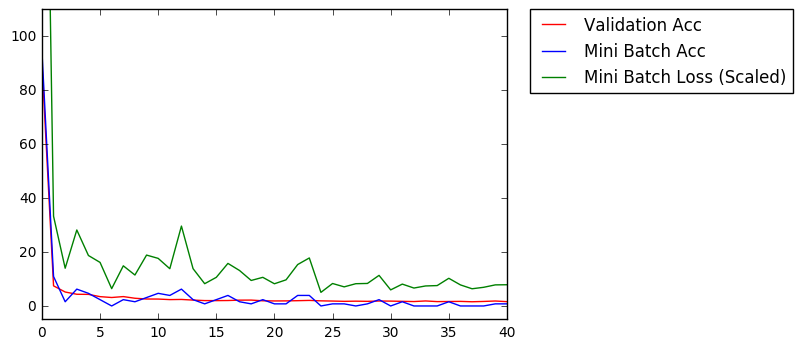

Test accuracy: 98.2%
{'l2_regularization_rate': 1e-05, 'batch_size': 128, 'dropout_prob1': 2, 'image_size': 28, 'depth': 16, 'num_hidden1': 84, 'learning_decay': 0.97, 'num_hidden0': 120, 'num_log_steps': 500, 'patch_size': 5, 'num_steps': 20001, 'learning_decay_steps': 4000, 'num_channels': 1, 'num_labels': 10, 'learning_startrate': 0.01, 'log_folder': '../logs', 'pooling_patch_size': 5}


In [14]:
log_data = {
    "mini_batch_loss" : [],
    "mini_batch_acc" : [],
    "validation_acc" : [],
    "stepsize" : param['num_log_steps']
}

start_time = time.time()
with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=True)) as session:
    
  session.run(tf.initialize_all_variables())

  RUN_NUMBER += 1  
  print('Initialized')
  for step in range(param['num_steps']):
        
    offset = (step * param['batch_size']) % (train_labels.shape[0] - param['batch_size'])
    
    batch_data = train_data[offset:(offset + param['batch_size']), :, :, :]
    
    batch_labels = train_labels[offset:(offset + param['batch_size']), :]
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    _, l, predictions = session.run([training, error, train_prediction], feed_dict=feed_dict)
    
    if (step % param["num_log_steps"] == 0):
      clear_output()
    
      print("Offset: {}".format(offset))
      print("Progress: {:5.2f}%".format( step*100 / param['num_steps']) )
      print("Elapsed Time: {:4.2f} min".format( (time.time() - start_time) / 60 ))
      print("Minibatch loss at step %d: %f" % (step, l))
      log_data["mini_batch_loss"].append(l * 100)
        
      mini_batch_acc = accuracy(predictions, batch_labels)
      print("Minibatch accuracy: %.1f%%" % mini_batch_acc)
      log_data["mini_batch_acc"].append(100.0 - mini_batch_acc)
    
      val_acc = accuracy( valid_prediction.eval(), validation_labels )
      print("Validation accuracy: %.1f%%" % val_acc )
      log_data["validation_acc"].append(100.0 - val_acc)
      plot_log_data(log_data)
      
      tf_minibatch_acc = mini_batch_acc
      tf_validation_acc = val_acc
        
      tf.scalar_summary("validation_accuracy", tf_validation_acc)
      tf.scalar_summary("minibatch_accuracy", tf_minibatch_acc)
    
      if(step == 0):
        all_summaries = tf.merge_all_summaries()
        log_dir = "%s/%i : %s" % (param["log_folder"], RUN_NUMBER, time.ctime())
        summary_writer = tf.train.SummaryWriter(log_dir, session.graph)
        
      #logging the error for tensorboard
      summary_str = session.run(all_summaries, feed_dict=feed_dict)
      summary_writer.add_summary(summary_str, step)
      summary_writer.flush()
  
  test_acc = accuracy( test_prediction.eval(), test_labels )
  print("Test accuracy: %.1f%%" % test_acc )
  print(param)
  with tf.name_scope("accuracy"):   
    tf.scalar_summary("validation_accuracy", val_acc)
    tf.scalar_summary("minibatch_accuracy", mini_batch_acc)
    tf.scalar_summary("test_accuracy", test_acc)